In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [20]:
#source:https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
df = pd.read_csv('Consumer_Complaints.csv')

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,01/19/2017,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,01/19/2017,Closed with explanation,Yes,No,2296496
2,04/06/2018,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,04/06/2018,Closed with explanation,Yes,NaN,2866101
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [4]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
#删除空值
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']

In [5]:
#将product列映射为category_id
df['category_id'] = df['Product'].factorize()[0]

#去重
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

#对category_id字典化
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df

,Product,Consumer_complaint_narrative,category_id
1,Student loan,When my loan was switched over to Navient i wa...,0
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...,1
7,Mortgage,"My mortgage is with BB & T Bank, recently I ha...",2
14,Mortgage,The entire lending experience with Citizens Ba...,2
15,Credit reporting,My credit score has gone down XXXX points in t...,3
17,"Credit reporting, credit repair services, or o...",I few months back I contacted XXXX in regards...,4
28,"Credit reporting, credit repair services, or o...",I '' m a victim of fraud and I have a file wit...,4
30,Mortgage,"My mortgage is owned by XXXX, we have painfull...",2
32,"Credit reporting, credit repair services, or o...",I have been disputing a Bankruptcy on my credi...,4
54,Debt collection,Today I received a phone call from a number li...,5


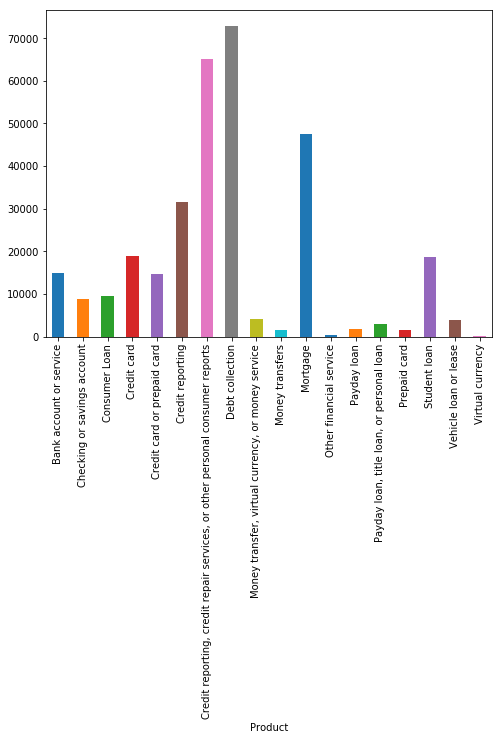

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [18]:
# sublinear_df is set to True to use a logarithmic form for frequency.
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
print(features)

  (0, 331190)	0.06398003487904703
  (0, 550999)	0.09617680570081022
  (0, 367133)	0.14980707724634992
  (0, 567621)	0.07528904423878505
  (0, 66373)	0.07778153857105698
  (0, 615473)	0.03792732545126351
  (0, 182389)	0.03296816675961945
  (0, 253460)	0.05055032878718216
  (0, 444098)	0.06329314663160657
  (0, 594591)	0.07307988869174852
  (0, 188419)	0.07565270332746632
  (0, 154193)	0.05907203447558985
  (0, 505621)	0.09609057693592746
  (0, 199258)	0.0788190473915842
  (0, 222504)	0.13832105431855124
  (0, 404483)	0.05403520473834076
  (0, 543712)	0.06243385905555771
  (0, 127049)	0.03592316585844362
  (0, 175521)	0.13775591897594083
  (0, 141495)	0.044594166375523915
  (0, 486531)	0.06111848272907206
  (0, 300937)	0.050071817789601
  (0, 308194)	0.06925438766152467
  (0, 306362)	0.0768842005282033
  (0, 140437)	0.047880029396605246
  :	:
  (318717, 521511)	0.12824905936181136
  (318717, 478709)	0.11657254453663965
  (318717, 149116)	0.13385464223777577
  (318717, 410986)	0.199806960

In [9]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. bank
. overdraft
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Checking or savings account':
  . Most correlated unigrams:
. overdraft
. deposit
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. car
  . Most correlated bigrams:
. santander consumer
. auto loan
# 'Credit card':
  . Most correlated unigrams:
. macy
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. express
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. equifax
. experian
  . Most correlated bigrams:
. verify accounts
. credit report
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. inquiries
. equifax
  . Most correlated bigrams:
. report underst

In [21]:
features_chi2 = chi2(features, labels == category_id)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

In [22]:
feature_names

array([u'protection', u'tried', u'open', ..., u'com 75', u'steps stated',
       u'bonus changed'], dtype='<U74')